# Extract transaction database

Here, we will extract transactions to be used for generating association rules. The source dataset is stored in the `../original` directory.

# 1. Examine data quality

First, let's load up the data and take a look at the quality of this dataset.

In [43]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../original/latestdata.csv.gz', low_memory=False)
print("%s rows x %s columns" % (data.shape[0], data.shape[1]))
data.head()

261558 rows x 34 columns


,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-,30-39,female,Snohomish County,Washington,United States,1.0,48.048180,-121.696000,admin2,...,NaN,NaN,NaN,NaN,Snohomish County,Washington,United States,2988,NaN,NaN
1,000-1-,NaN,NaN,NaN,Khuzestan,Iran,1.0,31.496225,48.967279,admin1,...,NaN,NaN,NaN,NaN,NaN,Khuzestan,Iran,15,NaN,NaN
2,000-1-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000-1-,50-59,male,Snohomish County,Washington,United States,1.0,48.048180,-121.696000,admin2,...,NaN,NaN,NaN,NaN,Snohomish County,Washington,United States,2988,NaN,NaN
4,000-1-,NaN,NaN,NaN,Pays de la Loire,France,1.0,47.486460,-0.811280,admin1,...,NaN,NaN,NaN,NaN,NaN,Pays de la Loire,France,12,NaN,NaN


Okay, looks good, but also a lot of null (NaN) values. Let's count up the data actually present.

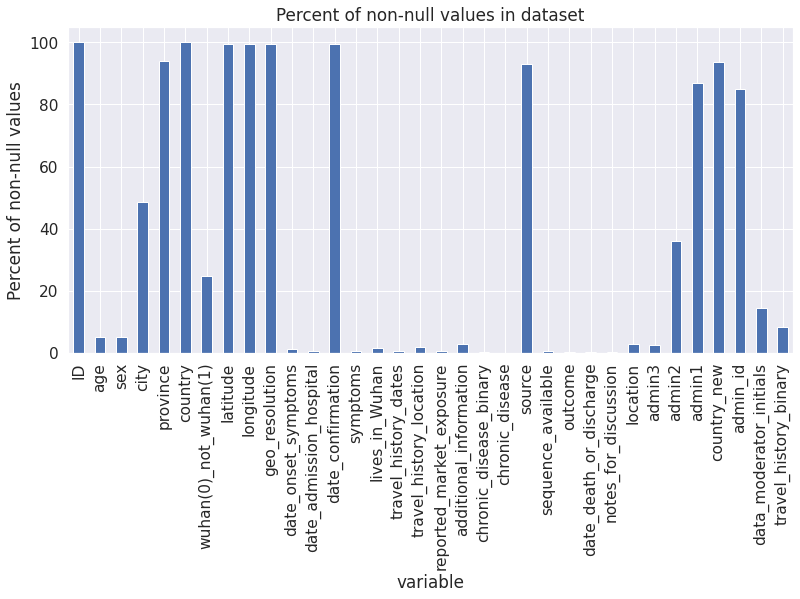

In [44]:
(100*data.count()/len(data)).plot(kind='bar', figsize=(13,6))
plt.xlabel('variable')
plt.ylabel('Percent of non-null values')
plt.title('Percent of non-null values in dataset')
plt.show()

So, looks like some variables (like ID, province, country) are present in most of the rows of the dataset. But other variables (like symptoms, date_onset_symptoms) have minimal information recorded.

Let's look at a heatmap of what values are present.

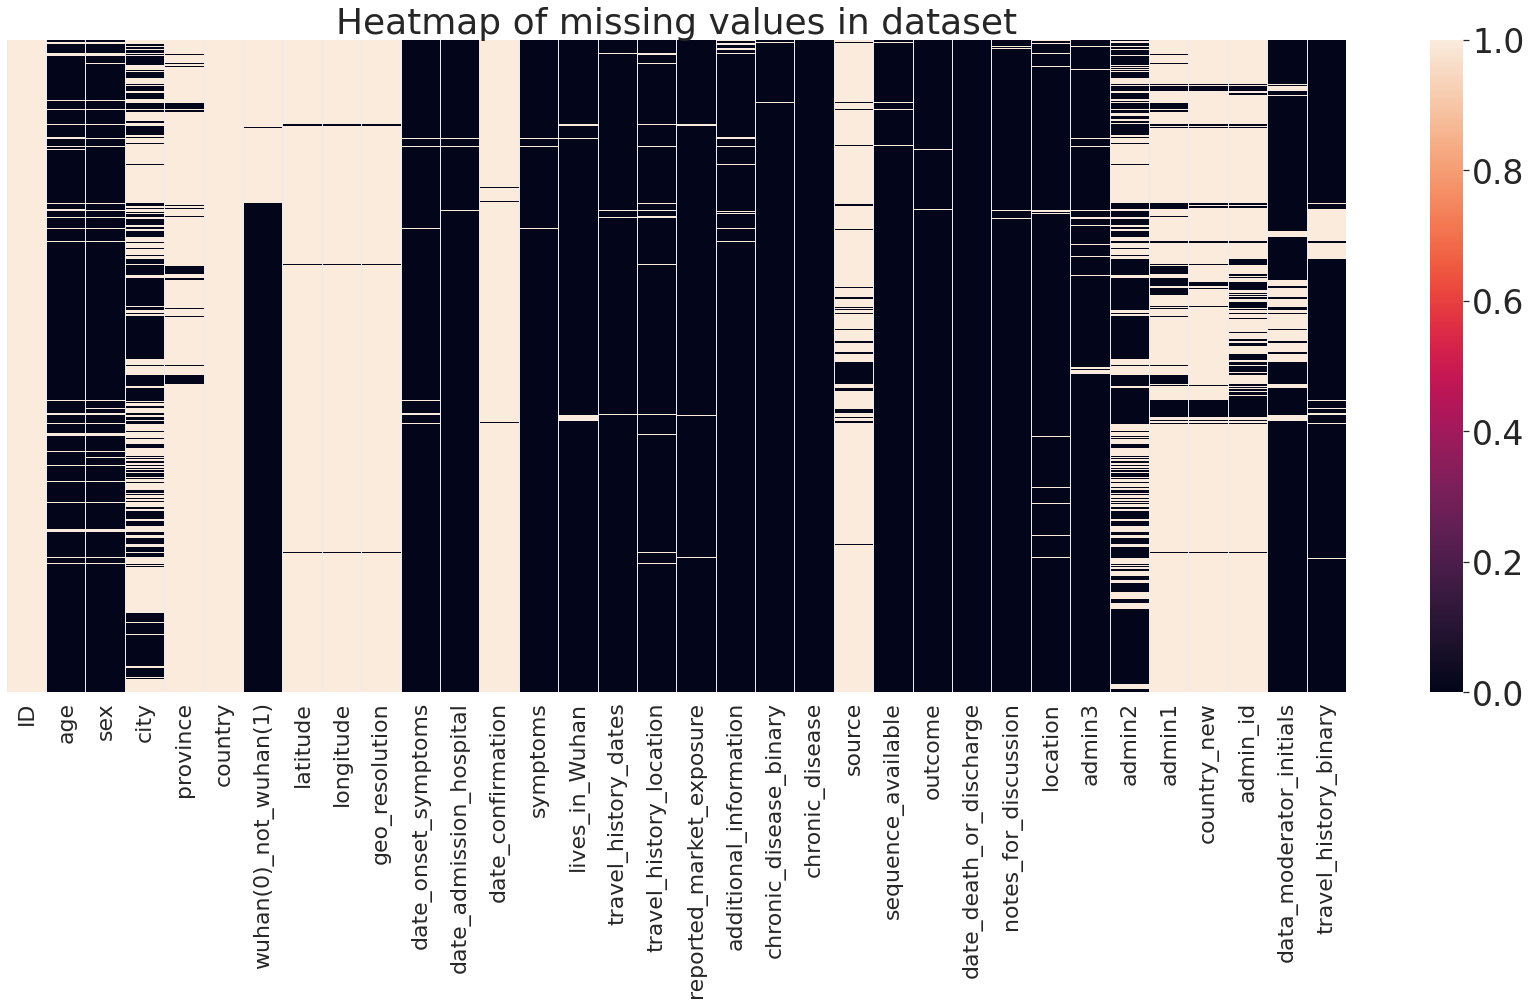

In [47]:
plt.subplots(figsize=(30,12))
sns.set(font_scale=3.0)
sns.heatmap(~data.isnull(), yticklabels=False)
plt.title('Heatmap of missing values in dataset')
plt.show()

Black is null, beige is a present data value. This gives us an overview of which missing values correlate with each other.

# 2. Data for mining

Let's now narrow down into some data we will be interested in mining.

In [232]:
data_symptoms=data[['symptoms']].dropna()
data_symptoms

,symptoms
16,"cough, fever, weakness"
137,"cough, diarrhea, fever, rhinorrhoea, sneezing"
151,pneumonitis
164,pneumonitis
224,pneumonitis
...,...
196197,"cough, body aches, chills"
196198,cough
209045,mild
209985,"cough, fever, nausea"


So, we only have around 1500 entries with symptoms associated with them.

Let's look more in-depth at all the unique symptoms listed.

In [233]:
def unique_symptom_counts(df):
    split_symptoms = df['symptoms'].str.split(',').values.tolist()
    unique_symptoms = [item for items in split_symptoms for item in items]
    return {item:unique_symptoms.count(item) for item in unique_symptoms}

def print_symptom_set(s):
    c = 0
    for k,v in s.items():
        if c > 20:
            break
        print(f"'{k}': '{v}'")
        c += 1
    print(f"\nTotal: {len(s)}")
    
unique_symptoms_count = unique_symptom_counts(data_symptoms)
print_symptom_set(unique_symptoms_count)

'cough': '316'
' fever': '282'
' weakness': '10'
' diarrhea': '11'
' rhinorrhoea': '2'
' sneezing': '8'
'pneumonitis': '38'
'anhelation': '2'
' cough': '142'
' pleural effusion': '2'
'diarrhea': '7'
' nasal congestion': '9'
' pleuritic chest pain': '2'
' sore throat': '71'
'fever': '471'
'dizziness': '3'
' sore limbs': '2'
'pneumonia': '20'
' severe pneumonia': '2'
'eye irritation': '1'
' runny nose': '29'

Total: 352


Okay, so there's a bit of cleanup work to do to remove whitespace, and standardize language in symptoms list.

# 3. Data cleaning

Let's try and clean up/standardize the symptoms. Let's look at the one symptom that doesn't appear to be in English.

In [234]:
data_symptoms[data_symptoms['symptoms'].str.contains('moderados')]

,symptoms
150706,"febre, tosse, e sintomas respirat‚àö‚â•rios mo..."


I'm thinking I'll remove it since I don't know the exact translation and it has characters that seemed to be messing up some commands.

In [235]:
symptoms_fix1 = data_symptoms[~data_symptoms['symptoms'].str.contains('moderados')]

Now, let's try and clean up some of the characters.

In [288]:
# Fix up separators between symptoms (sometimes there was , or ; or :)
# Set to lower case
symptoms_fix2 = pd.DataFrame(symptoms_fix1['symptoms'].str.lower().str.replace(
    ', *and', ',').str.replace(
    'and', ',').str.replace(
    ';',',').str.replace(':',',').str.replace(
    ' *,',',').str.replace(', *',','))
print_symptom_set(unique_symptom_counts(symptoms_fix2))

'cough': '526'
'fever': '825'
'weakness': '12'
'diarrhea': '20'
'rhinorrhoea': '2'
'sneezing': '15'
'pneumonitis': '38'
'anhelation': '2'
'pleural effusion': '2'
'nasal congestion': '11'
'pleuritic chest pain': '2'
'sore throat': '110'
'dizziness': '6'
'sore limbs': '2'
'pneumonia': '73'
'severe pneumonia': '6'
'eye irritation': '1'
'runny nose': '45'
'dyspnea': '21'
'difficulty breathing': '6'
'headache': '68'

Total: 260


In [305]:
symptoms_fix3 = pd.DataFrame(symptoms_fix2['symptoms'].str.replace(
    '(37.5 ℃,then 38 ℃)', '(37.5 ℃ then 38 ℃)').str.replace(
    '[^,]*fever[^,]*', 'fever').str.replace(
    'dcough', 'cough').str.replace(
    'coughing', 'cough').str.replace(
    'dry cough', 'cough').str.replace(
    'cough symptoms', 'cough').str.replace(
    'couh', 'cough').str.replace(
    'sore throath', 'sore throat').str.replace(
    'sore throa[^t]', 'sore throat').str.replace(
    'cough difficulty breathing', 'cough,difficulty breathing').str.replace(
    'mile cough', 'cough').str.replace(
    'mild resipiratory symptoms', 'mild respiratory symptoms').str.replace(
    'mild respiratory symptoms', 'respiratory symptoms').str.replace(
    'symptoms associated with a respiratory condition', 'respiratory symptoms').str.replace(
    'no clinical symptoms', 'none').str.replace(
    'fatigure', 'fatigue').str.replace(
    'tired', 'fatigue').str.replace(
    'general malaise', 'malaise'))
print_symptom_set(unique_symptom_counts(symptoms_fix3))

'cough': '564'
'fever': '1005'
'weakness': '12'
'diarrhea': '20'
'rhinorrhoea': '2'
'sneezing': '15'
'pneumonitis': '38'
'anhelation': '2'
'pleural effusion': '2'
'nasal congestion': '11'
'pleuritic chest pain': '2'
'sore throat': '114'
'dizziness': '6'
'sore limbs': '2'
'pneumonia': '73'
'severe pneumonia': '6'
'eye irritation': '1'
'runny nose': '45'
'dyspnea': '21'
'difficulty breathing': '8'
'headache': '68'

Total: 177


Making a bit of progress. Let's save this list right now, and maybe revisit later.

# 4. Save symptoms list

In [306]:
expanded_symptoms = symptoms_fix3['symptoms'].str.split(',', expand = True)
expanded_symptoms

,0,1,2,3,4,5
16,cough,fever,weakness,None,None,None
137,cough,diarrhea,fever,rhinorrhoea,sneezing,None
151,pneumonitis,None,None,None,None,None
164,pneumonitis,None,None,None,None,None
224,pneumonitis,None,None,None,None,None
...,...,...,...,...,...,...
196197,cough,body aches,chills,None,None,None
196198,cough,None,None,None,None,None
209045,mild,None,None,None,None,None
209985,cough,fever,nausea,None,None,None


In [308]:
expanded_symptoms.to_csv('symptoms.tsv', sep="\t", header=False, index=False)